In [ ]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):
    
    nfeatures = 100
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4)
        + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, random_state=random_state)

## Train GAMI-Net 

In [3]:
model = GAMINet(meta_info=meta_info, interact_num=20, 
                interact_arch=[40] * 5, subnet_arch=[40] * 5, 
                batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, 
                lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                verbose=True, val_ratio=0.2, random_state=random_state)
model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.03528, val loss: 0.03443
Main effects training epoch: 2, train loss: 0.01994, val loss: 0.02006
Main effects training epoch: 3, train loss: 0.01963, val loss: 0.01961
Main effects training epoch: 4, train loss: 0.01954, val loss: 0.01957
Main effects training epoch: 5, train loss: 0.01946, val loss: 0.01951
Main effects training epoch: 6, train loss: 0.01938, val loss: 0.01943
Main effects training epoch: 7, train loss: 0.01928, val loss: 0.01934
Main effects training epoch: 8, train loss: 0.01916, val loss: 0.01924
Main effects training epoch: 9, train loss: 0.01903, val loss: 0.01913
Main effects training epoch: 10, train loss: 0.01888, val loss: 0.01899
Main effects training epoch: 11, train loss: 0.01868, val loss: 0.01881
Main effects training epoch: 12, train loss: 0.01842, val loss: 0.01861
Main effects training e

Main effects training epoch: 210, train loss: 0.01059, val loss: 0.01113
Main effects training epoch: 211, train loss: 0.01075, val loss: 0.01131
Main effects training epoch: 212, train loss: 0.01065, val loss: 0.01120
Main effects training epoch: 213, train loss: 0.01070, val loss: 0.01124
Main effects training epoch: 214, train loss: 0.01065, val loss: 0.01121
Main effects training epoch: 215, train loss: 0.01058, val loss: 0.01109
Main effects training epoch: 216, train loss: 0.01063, val loss: 0.01117
Main effects training epoch: 217, train loss: 0.01062, val loss: 0.01113
Main effects training epoch: 218, train loss: 0.01057, val loss: 0.01111
Main effects training epoch: 219, train loss: 0.01059, val loss: 0.01111
Main effects training epoch: 220, train loss: 0.01058, val loss: 0.01112
Main effects training epoch: 221, train loss: 0.01058, val loss: 0.01111
Main effects training epoch: 222, train loss: 0.01058, val loss: 0.01111
Main effects training epoch: 223, train loss: 0.010

Interaction training epoch: 13, train loss: 0.00693, val loss: 0.00681
Interaction training epoch: 14, train loss: 0.00675, val loss: 0.00664
Interaction training epoch: 15, train loss: 0.00657, val loss: 0.00647
Interaction training epoch: 16, train loss: 0.00641, val loss: 0.00632
Interaction training epoch: 17, train loss: 0.00630, val loss: 0.00623
Interaction training epoch: 18, train loss: 0.00625, val loss: 0.00617
Interaction training epoch: 19, train loss: 0.00608, val loss: 0.00603
Interaction training epoch: 20, train loss: 0.00606, val loss: 0.00602
Interaction training epoch: 21, train loss: 0.00601, val loss: 0.00598
Interaction training epoch: 22, train loss: 0.00588, val loss: 0.00586
Interaction training epoch: 23, train loss: 0.00582, val loss: 0.00580
Interaction training epoch: 24, train loss: 0.00577, val loss: 0.00574
Interaction training epoch: 25, train loss: 0.00574, val loss: 0.00570
Interaction training epoch: 26, train loss: 0.00568, val loss: 0.00569
Intera

Interaction training epoch: 128, train loss: 0.00330, val loss: 0.00341
Interaction training epoch: 129, train loss: 0.00329, val loss: 0.00338
Interaction training epoch: 130, train loss: 0.00325, val loss: 0.00334
Interaction training epoch: 131, train loss: 0.00325, val loss: 0.00335
Interaction training epoch: 132, train loss: 0.00325, val loss: 0.00333
Interaction training epoch: 133, train loss: 0.00326, val loss: 0.00340
Interaction training epoch: 134, train loss: 0.00317, val loss: 0.00326
Interaction training epoch: 135, train loss: 0.00315, val loss: 0.00322
Interaction training epoch: 136, train loss: 0.00314, val loss: 0.00323
Interaction training epoch: 137, train loss: 0.00311, val loss: 0.00323
Interaction training epoch: 138, train loss: 0.00310, val loss: 0.00317
Interaction training epoch: 139, train loss: 0.00305, val loss: 0.00316
Interaction training epoch: 140, train loss: 0.00306, val loss: 0.00319
Interaction training epoch: 141, train loss: 0.00304, val loss: 

Interaction training epoch: 242, train loss: 0.00215, val loss: 0.00231
Interaction training epoch: 243, train loss: 0.00212, val loss: 0.00230
Interaction training epoch: 244, train loss: 0.00213, val loss: 0.00229
Interaction training epoch: 245, train loss: 0.00210, val loss: 0.00228
Interaction training epoch: 246, train loss: 0.00209, val loss: 0.00225
Interaction training epoch: 247, train loss: 0.00210, val loss: 0.00227
Interaction training epoch: 248, train loss: 0.00216, val loss: 0.00234
Interaction training epoch: 249, train loss: 0.00211, val loss: 0.00228
Interaction training epoch: 250, train loss: 0.00214, val loss: 0.00231
Interaction training epoch: 251, train loss: 0.00216, val loss: 0.00236
Interaction training epoch: 252, train loss: 0.00210, val loss: 0.00227
Interaction training epoch: 253, train loss: 0.00212, val loss: 0.00229
Interaction training epoch: 254, train loss: 0.00213, val loss: 0.00230
Interaction training epoch: 255, train loss: 0.00211, val loss: 

Interaction training epoch: 356, train loss: 0.00198, val loss: 0.00223
Interaction training epoch: 357, train loss: 0.00200, val loss: 0.00225
Interaction training epoch: 358, train loss: 0.00199, val loss: 0.00224
Interaction training epoch: 359, train loss: 0.00198, val loss: 0.00224
Interaction training epoch: 360, train loss: 0.00198, val loss: 0.00221
Early stop at epoch 360, with validation loss: 0.00221
##########Stage 2: interaction training stop.##########
Fine tuning epoch: 1, train loss: 0.00212, val loss: 0.00219
Fine tuning epoch: 2, train loss: 0.00213, val loss: 0.00220
Fine tuning epoch: 3, train loss: 0.00214, val loss: 0.00223
Fine tuning epoch: 4, train loss: 0.00213, val loss: 0.00221
Fine tuning epoch: 5, train loss: 0.00213, val loss: 0.00220
Fine tuning epoch: 6, train loss: 0.00213, val loss: 0.00220
Fine tuning epoch: 7, train loss: 0.00208, val loss: 0.00215
Fine tuning epoch: 8, train loss: 0.00210, val loss: 0.00219
Fine tuning epoch: 9, train loss: 0.00209

Fine tuning epoch: 126, train loss: 0.00210, val loss: 0.00217
Fine tuning epoch: 127, train loss: 0.00213, val loss: 0.00222
Fine tuning epoch: 128, train loss: 0.00205, val loss: 0.00215
Fine tuning epoch: 129, train loss: 0.00208, val loss: 0.00217
Fine tuning epoch: 130, train loss: 0.00207, val loss: 0.00217
Fine tuning epoch: 131, train loss: 0.00207, val loss: 0.00217
Fine tuning epoch: 132, train loss: 0.00207, val loss: 0.00217
Fine tuning epoch: 133, train loss: 0.00205, val loss: 0.00216
Early stop at epoch 133, with validation loss: 0.00216
####################GAMI-Net training finished.####################
[1.01717 1.04375 1.01781]


## Visualization

In [4]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

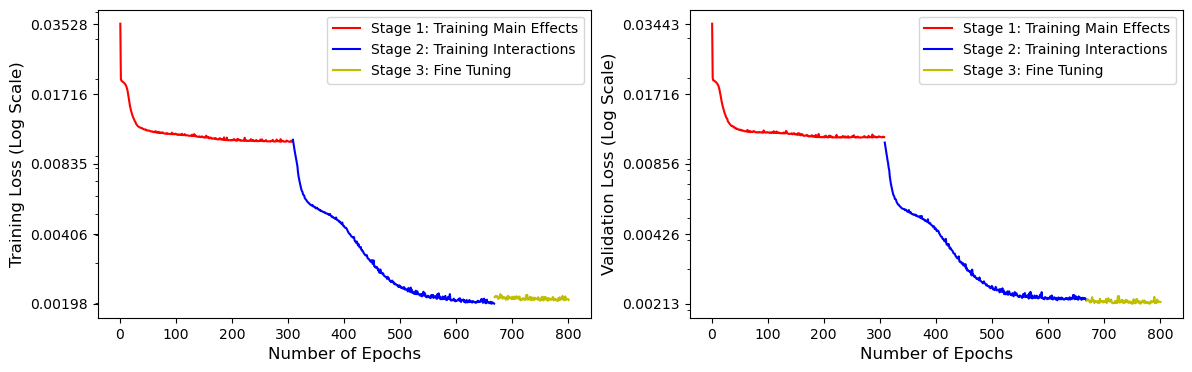

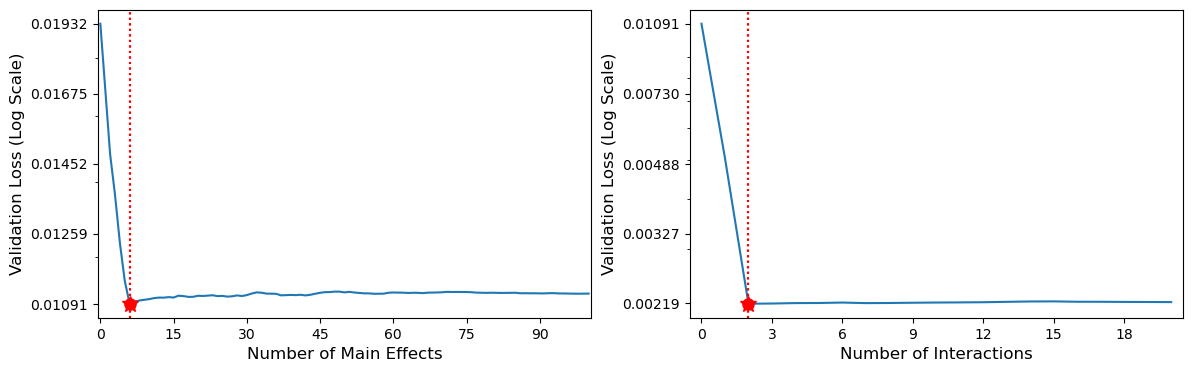

In [5]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

Global Visualization

In [6]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=True, folder=simu_dir, name='s1_global')

Feature Importance

In [7]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [8]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

In [9]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

In [10]:
local_visualize(data_dict_local[1], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [11]:
model.save(folder="./", name="model_saved")

In [12]:
## The reloaded model should not be refit again
modelnew = GAMINet(meta_info={})
modelnew.load(folder="./", name="model_saved")

# Shape constraints

In [13]:
model = GAMINet(meta_info=meta_info, interact_num=20, 
                interact_arch=[40] * 5, subnet_arch=[40] * 5, 
                batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, 
                lr_bp=[0.001, 0.001, 0.001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                mono_increasing_list=None,
                mono_decreasing_list=[1],
                convex_list=[0], lattice_size=10,
                verbose=True, val_ratio=0.2, random_state=random_state)
model.fit(train_x, train_y)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########


Main effects training epoch: 1, train loss: 0.02066, val loss: 0.02082
Main effects training epoch: 2, train loss: 0.01962, val loss: 0.01976
Main effects training epoch: 3, train loss: 0.01828, val loss: 0.01853
Main effects training epoch: 4, train loss: 0.01712, val loss: 0.01748
Main effects training epoch: 5, train loss: 0.01617, val loss: 0.01654
Main effects training epoch: 6, train loss: 0.01477, val loss: 0.01526
Main effects training epoch: 7, train loss: 0.01402, val loss: 0.01465
Main effects training epoch: 8, train loss: 0.01408, val loss: 0.01448
Main effects training epoch: 9, train loss: 0.01361, val loss: 0.01394
Main effects training epoch: 10, train loss: 0.01295, val loss: 0.01338
Main effects training epoch: 11, train loss: 0.01312, val loss: 0.01346
Main effects training epoch: 12, train loss: 0.01260, val loss: 0.01303
Main effects training epoch: 13, train loss: 0.01236, val loss: 0.01285
Main effects training epoch: 14, train loss: 0.01240, val loss: 0.01283
M

AttributeError: in user code:

    /home/r7user1/anaconda2_local/envs/py37/lib/python3.7/site-packages/gaminet/gaminet.py:232 train_interaction  *
        pred = self.__call__(inputs, sample_weight, main_effect_training=False, interaction_training=True)
    /home/r7user1/anaconda2_local/envs/py37/lib/python3.7/site-packages/gaminet/gaminet.py:148 call  *
        self.interact_outputs = self.interact_blocks(inputs, sample_weight, training=interaction_training)
    /home/r7user1/anaconda2_local/envs/py37/lib/python3.7/site-packages/gaminet/layers.py:450 call  *
        interact_output = interact(interact_input, sample_weight=sample_weight, training=training)
    /home/r7user1/anaconda2_local/envs/py37/lib/python3.7/site-packages/gaminet/layers.py:361 call  *
        lattice_input2d = tf.keras.layers.Concatenate(axis=1)([self.lattice_layer_input1(x[0]), self.lattice_layer_input2(x[1])])

    AttributeError: 'MonoConInteractnetwork' object has no attribute 'lattice_layer_input2'


In [ ]:
model.

In [ ]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=False)